<a href="https://colab.research.google.com/github/bilaloumehdi/TP_NLP/blob/master/TP3/TP3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install kaggle and authenticate**

In [3]:
#install kaggle
!pip install kaggle

In [5]:
# authenticate to kaggle
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### **Download the dataset and unzip it**

In [7]:
!kaggle datasets download -d nltkdata/movie-review

 71% 5.00M/7.07M [00:00<00:00, 42.1MB/s]
100% 7.07M/7.07M [00:00<00:00, 56.8MB/s]


In [8]:
#unzip
!unzip movie-review.zip

Archive:  movie-review.zip
  inflating: README                  
  inflating: movie_review.csv        
  inflating: movie_reviews-meta.json  
  inflating: movie_reviews/movie_reviews/README  
  inflating: movie_reviews/movie_reviews/neg/cv000_29416.txt  
  inflating: movie_reviews/movie_reviews/neg/cv001_19502.txt  
  inflating: movie_reviews/movie_reviews/neg/cv002_17424.txt  
  inflating: movie_reviews/movie_reviews/neg/cv003_12683.txt  
  inflating: movie_reviews/movie_reviews/neg/cv004_12641.txt  
  inflating: movie_reviews/movie_reviews/neg/cv005_29357.txt  
  inflating: movie_reviews/movie_reviews/neg/cv006_17022.txt  
  inflating: movie_reviews/movie_reviews/neg/cv007_4992.txt  
  inflating: movie_reviews/movie_reviews/neg/cv008_29326.txt  
  inflating: movie_reviews/movie_reviews/neg/cv009_29417.txt  
  inflating: movie_reviews/movie_reviews/neg/cv010_29063.txt  
  inflating: movie_reviews/movie_reviews/neg/cv011_13044.txt  
  inflating: movie_reviews/movie_reviews/neg/cv012_29

### **Preprocessing**

**Read data**

In [235]:
import pandas as pd
#load the data
df = pd.read_csv('./movie_review.csv')

df.head()


,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


**Extract text and tag columns**

In [236]:
# extract the text
text = df['text']
text.head()

0    films adapted from comic books have had plenty...
1    for starters , it was created by alan moore ( ...
2    to say moore and campbell thoroughly researche...
3    the book ( or " graphic novel , " if you will ...
4    in other words , don't dismiss this film becau...
Name: text, dtype: object

In [237]:
tags_map = {'pos':1, 'neg':0}
tags = df['tag']
tags = tags.map(tags_map)
tags.head()

0    1
1    1
2    1
3    1
4    1
Name: tag, dtype: int64

**Preprocessing functions**

we define here all the functions that will be needed for preprocessing text before vectorization

In [238]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stopwords = set(stopwords.words('english'))

def tolower(text):
  return [t.lower() for t in text]

def remove_punctuation(sentence):
  return ''.join([char for char in sentence if char not in string.punctuation])

def remove_stopwords(words):
  return [word for word in words if word not in stopwords]

def lemmatize(words):
  lemmatizer  =  WordNetLemmatizer()
  return [lemmatizer.lemmatize(word) for word in words]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [239]:
'''
this function will take a text and apply all the preprocessing steps
 --> call all the above functions from converting text to lower case until lemmatization

 returns : the processed text

'''
def preprocess(text_list):
  # convet sentences to lowercase
  text_list = tolower(text_list)

  # remove ponctuation
  text_list = [remove_punctuation(t) for t in text_list]

  # tokenization
  text_list = [nltk.word_tokenize(t) for t in text_list]

  # remove stepwords
  text_list = [remove_stopwords(t) for t in text_list]

  # lemmatisation
  text_list = [lemmatize(t) for t in text_list]

  return text_list


**Apply the Preprocessing**

In [240]:
text_list = text.values.tolist()
preprocessed_text = preprocess(text_list)
preprocessed_text[0]

['film',
 'adapted',
 'comic',
 'book',
 'plenty',
 'success',
 'whether',
 'theyre',
 'superheroes',
 'batman',
 'superman',
 'spawn',
 'geared',
 'toward',
 'kid',
 'casper',
 'arthouse',
 'crowd',
 'ghost',
 'world',
 'there',
 'never',
 'really',
 'comic',
 'book',
 'like',
 'hell']

### **Word2Vec**

**Train model**

In [244]:
from gensim.models import Word2Vec
import numpy as np

# train the model
model = Word2Vec(preprocessed_text,vector_size= 100,min_count=1,workers=4)

#model.save('movie-review.model')


**Vectorization**

In [245]:

''' a function that will vectorize a sentence based on calculating the mean
    of the sentence's words vectors
'''
def vectorize_sentence(sentence,vector_size = 100):

  words_vectors = [model.wv[word] for word in sentence if word in model.wv]
  if not words_vectors:
    return np.zeros(vector_size)

  return np.mean(words_vectors,axis=0)

# vectorize the entire text
def vectorize(text):
  return [vectorize_sentence(sentence,model.vector_size) for sentence in text]


**Apply vectorization**

In [247]:
vectorized_text = vectorize(preprocessed_text)
vectorized_text[:2]

[array([-0.5033191 ,  0.6695498 ,  0.16497271, -0.04756067, -0.03876413,
        -0.6292331 ,  0.1943184 ,  1.1850157 , -0.40067074, -0.15605171,
        -0.02606299, -0.79614437, -0.00374413,  0.4398472 ,  0.16113463,
        -0.6523009 ,  0.07075255, -0.47751135, -0.22730845, -1.0258341 ,
         0.4735991 ,  0.17318453,  0.35879874, -0.25138515, -0.10455777,
        -0.06404648, -0.29283544, -0.19684193, -0.5122348 , -0.06539985,
         0.4060206 , -0.08575588,  0.09778161, -0.44325066, -0.16176134,
         0.4176776 ,  0.37131196, -0.41209316, -0.29264244, -0.9005408 ,
        -0.11420669, -0.32623354, -0.23886193,  0.29927382,  0.5547117 ,
        -0.13015237, -0.31779292,  0.07633342,  0.20923413,  0.30367407,
         0.24219406, -0.36965767, -0.27924538, -0.33407825, -0.28477028,
         0.10777871,  0.4070132 , -0.15063298, -0.42775747,  0.21565601,
         0.0141307 ,  0.08642181, -0.18936546, -0.09405686, -0.66620684,
         0.3398514 ,  0.24309383,  0.5402024 , -0.4

### **Classification**

**spliting the data**

In [248]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_text,tags,test_size=0.3,random_state=42)
X_train[:2]

[array([-0.4827928 ,  0.40053135,  0.16548766, -0.18025692, -0.03606106,
        -0.6583201 ,  0.07924578,  1.0543283 , -0.44386813,  0.08641892,
        -0.27608764, -0.7099355 , -0.05328487,  0.59827745,  0.24774939,
        -0.54521555,  0.22494718, -0.49116728, -0.1792106 , -1.1598705 ,
         0.63225394,  0.48700455,  0.32188055, -0.07083306, -0.07474983,
         0.05371587, -0.38229567, -0.00324806, -0.54621726, -0.00640457,
         0.48938465, -0.02037077,  0.03468508, -0.4399441 , -0.2502046 ,
         0.47222936,  0.246366  , -0.38241643, -0.32477093, -0.5992436 ,
         0.02215005, -0.29846886, -0.1434763 ,  0.26542962,  0.49303976,
        -0.15188792, -0.5534572 ,  0.14972758,  0.09733975,  0.19352898,
         0.14070949, -0.5645525 , -0.29118812, -0.24774554, -0.19822505,
        -0.10027954,  0.4448959 , -0.24517451, -0.31770015,  0.29878446,
         0.06613395, -0.06835407,  0.09348217, -0.15017699, -0.7062414 ,
         0.3880185 ,  0.23170894,  0.48481336, -0.7

**train  and predict: Logistic Regression model**

In [249]:
from sklearn.linear_model import LogisticRegression

logisticReg = LogisticRegression(max_iter=800)
logisticReg_model = logisticReg.fit(X_train, y_train)
y_pred = logisticReg_model.predict(X_test)


**Results : metrics**

In [250]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


print("Accuracy: ",logisticReg_model.score(X_test,y_test))
print("Recall: ",recall_score(y_test,y_pred))
print("F1-score: ",f1_score(y_test,y_pred))
print("Precision: ",precision_score(y_test, y_pred))

Accuracy:  0.5715904408735064
Recall:  0.6691683569979716
F1-score:  0.6133680394161941
Precision:  0.5661575424746867


**Confusion matrix**

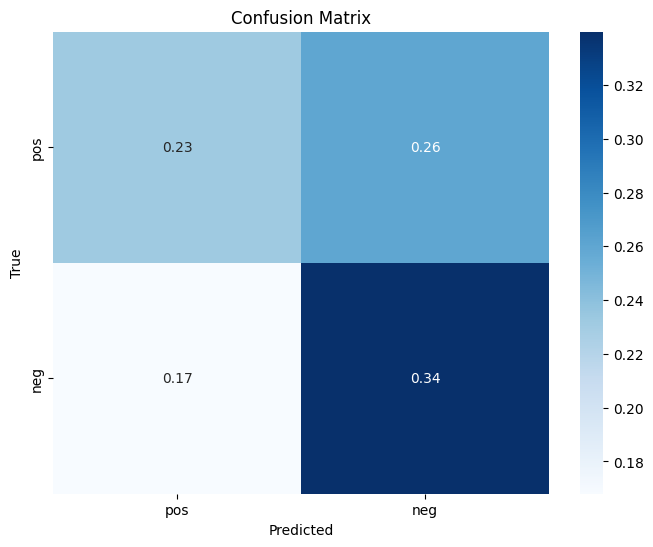

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test,y_pred,normalize="all")

class_labels = ['pos','neg']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### **Test prediction**

In [258]:
review = ['I love king Arther movie.']

preprocessed_review = preprocess(review)
vectorized_review = vectorize(review)

pred = logisticReg_model.predict(vectorized_review)

# 1 --> pos
# 0 --> neg
pred

array([1])